<a href="https://colab.research.google.com/github/VKapitany/Gaussian_Processes_Intro/blob/master/Gaussian_processes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import division
import numpy as np
from matplotlib import pyplot as plt

## Overview of Gaussian processes

1.   **What is a GP?**  Def: A GP is a collection of random variables, any finite number of which have consistent Gaussian distributions. I.e. a GP is the generalisation of a multivariate Gaussian to infinitely many variables.
2.   **How are GPs used in ML?** A machine-learning algorithm that involves a Gaussian process uses lazy learning and a measure of the similarity between points (the kernel function) to predict the value for an unseen point from training data.
3.   **What advantages do GPs offer?** The prediction is not just an estimate for that point, but also has uncertainty information—it is a one-dimensional Gaussian distribution.

(https://en.wikipedia.org/wiki/Gaussian_process)



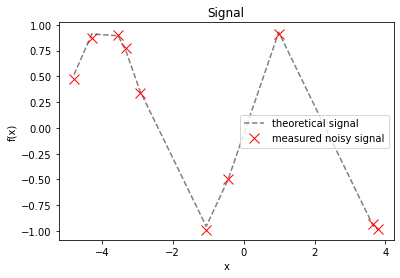

In [ ]:
N = 10         # number of training points.
n = 50         # number of test points.
s = 0.05   # noise variance.

# This is the true unknown function we are trying to approximate
f = lambda x: np.sin(1.2*x).flatten()
#f = lambda x: (0.25*(x**2)).flatten()

# Sample some input points and noisy versions of the function evaluated at
# these points. 
X = np.asarray(sorted(np.random.uniform(-5, 5, size=(N,1))))
y = f(X) + s*np.random.randn(N)

plt.clf()
plt.plot(X, f(X), 'gray',linestyle='--', label='theoretical signal')
plt.plot(X, y, 'rx', ms=10, label='measured noisy signal')
plt.title('Signal')
plt.ylabel('f(x)')
plt.xlabel('x')
plt.legend()
plt.show()

### Theory of GPs
adapted from 

https://www.youtube.com/watch?v=4vGiHC35j9s&feature=youtu.be

https://thegradient.pub/gaussian-process-not-quite-for-dummies/

---
A Gaussian process is fully specified by a mean vector $\textbf{$\mu$}$ and a covariance matrix $\Sigma$:

> $\textbf{f} = (f_1,...,f_n) \sim \mathcal{N}(\textbf{$\mu$},\Sigma)$, indices $i=1,...,n$


A Gaussian process is fully specified by a mean function $m(\textbf{x})$ and a covariance function $K(\textbf{x,x$^\prime$})$:

> $f(\textbf{x}) \sim GP (m(\textbf{x}),K(\textbf{x,x$^\prime$}))$, indices $\textbf{x}$

where 

$m(\textbf{x}) = \mathop{\mathbb{E}}[f(\textbf{x})]$

$K(\textbf{x,x$^\prime$}) = \mathop{\mathbb{E}}[(f(\textbf{x})-m(\textbf{x}))(f(\textbf{x$^\prime$})-m(\textbf{x$^\prime$})]$

with the prior that a quadratic kernel describes the covariance:

$k(x,x^\prime) = exp(-\frac{1}{2}(x-x^\prime$))



In [ ]:
""" This is code for simple GP regression. It assumes a zero mean GP Prior """

# Define the kernel
def kernel(a, b):
    """ GP squared exponential kernel """
    kernelParameter = 1
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/kernelParameter) * sqdist)

### Fitting a multivariate Gaussian to measurements $x$ to predict $x^\prime$

$f \sim \mathcal{N}(0,K) $

$f^\prime \sim \mathcal{N}(0,\color{green}{K(x^\prime x^\prime)})$

i.e.

$\begin{pmatrix}
  f \\
  f^\prime
 \end{pmatrix} \sim \mathcal{N} 
 \begin{pmatrix}
 0, 
 \begin{pmatrix}
  K_{11} & K_{12} & \cdots & \color{red}{K_{1\prime}} \\
  K_{21} & K_{22} & \cdots & \color{red}{K_{1\prime}} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  \color{red}{K_{\prime1}} & \color{red}{K_{\prime2}} & \cdots & \color{green}{K_{\prime\prime}}
 \end{pmatrix}
 \end{pmatrix}$

---

#### **Maximum a posteriori estimate of means and variances at test datapoints given by Multivariate Gaussian Theroem**

<center><img src="https://raw.githubusercontent.com/VKapitany/Gaussian_Processes_Intro/master/mgt.png" width=600>

*(see https://www.cs.ubc.ca/~nando/540-2013/lectures/l6.pdf Eq. 4.12)*</center>


>$\mu^\prime \equiv \mu_{f^\prime|f} \equiv \mathop{\mathbb{E}}[f^\prime] 
\\= \mu_{f^\prime} + \color{red}{K_{\prime}^T} K^{-1} (f-\mu_f) 
\\ = \color{red}{K_{\prime}^T} K^{-1}f \text{ [since $\mu_f$ = $\mu_{f^\prime}$ = 0]}$ 



>$\sigma^{\prime2} \equiv \sigma^{\prime2}_{f^\prime|f} 
\\ =\color{green}{K_{\prime\prime}} - \color{red}{K_{\prime}^T} K^{-1} \color{red}{K_{\prime}}$
---
To solve these equations, we use the Cholesky-decomposition, which is the equivalent of taking the square root of a matrix:
The Cholesky decomposition of a Hermitian positive-definite or semi-definite matrix $A$, is a decomposition of the form*

$A = LL^*$ or for A$\in\mathbb{R}^{m \times n}$, $A = LL^\intercal$;

So, we use Cholesky decomposition on $K = k(x,x)$ (where k is some kernel (quadratic in our case)): 

> $K = LL^\intercal$.

We then solve 
> $L\color{red}{L_k} = \color{red}{K_{\prime}} \Rightarrow \color{red}{L_k} = L^{-1}\color{red}{K_{\prime}}
\\LL_y = f(x) \equiv f \equiv y \Rightarrow L_y = L^{-1}y$ 

Then,
>$\mu^\prime = \color{red}{L_k^\intercal} Ly = \{L^{-1}\color{red}{K_{\prime}}\}^\intercal\{L^{-1}y\}
\\ = \{\color{red}{K_{\prime}^\intercal}L^{-1\intercal}\}\{L^{-1}y\} 
\\= \color{red}{K_{\prime}^\intercal}L^{-1\intercal} L^{-1}y 
\\= \color{red}{K_{\prime}^\intercal}\{LL^{\intercal}\}^{-1}y 
\\= \color{red}{K_{\prime}^\intercal}K^{-1}y 
\\=\color{red}{K_{\prime}}Ky =\color{red}{K_{\prime}}Kf$ 

(remember y is just defined to be $f(x)$ above, to differentiate it from the method `f(x)`)

$\sigma^{\prime2}$ may be obtained similarly
>$\sigma^{\prime2} = diag[\color{green}{K_{\prime\prime}} - \color{red}{L_k^\intercal}\color{red}{L_k}]
\\ = diag[\color{green}{K_{\prime\prime}} - \{L^{-1}\color{red}{K_{\prime}}\}^\intercal\{L^{-1}\color{red}{K_{\prime}}\}]
\\ = diag[\color{green}{K_{\prime\prime}} -\{\color{red}{K_{\prime}^\intercal}L^{-1\intercal}\}\{L^{-1}\color{red}{K_{\prime}}\}]
\\= diag[\color{green}{K_{\prime\prime}} -\color{red}{K_{\prime}^\intercal}K^{-1}\color{red}{K_{\prime}}]$





(-5.0, 5.0, -3.0, 3.0)

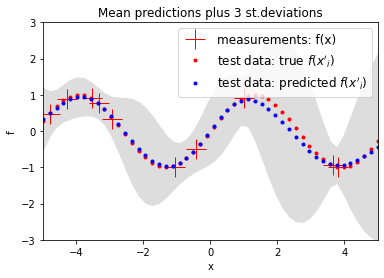

In [ ]:
K = kernel(X, X)
L = np.linalg.cholesky(K + s*np.eye(N)) # gaussian prior 

# points we're going to make predictions at.
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

# compute the mean at our test points.
Lk = np.linalg.solve(L, kernel(X, Xtest)) 
Ly = np.linalg.solve(L, y)
mu = np.matmul(Lk.T, Ly)

# compute the variance at our test points.
K_ = kernel(Xtest, Xtest) # K prime prime
Sigma = np.diag(K_ - np.matmul(Lk.T,Lk)) # original code has Sigma = np.diag(K_) - np.sum(Lk**2, axis=0)
                                         # which gives same answer
std = np.sqrt(Sigma)

plt.figure(1)
plt.clf()
plt.plot(X, y, 'r+', ms=20,label='measurements: f(x)')
plt.plot(Xtest, f(Xtest), 'r.',label='test data: true $f(x\'_i)$')
plt.gca().fill_between(Xtest.flat, mu-3*std, mu+3*std, color="#dddddd")
plt.plot(Xtest, mu, 'b.', lw=2,label='test data: predicted $f(x\'_i)$')
plt.title('Mean predictions plus 3 st.deviations')
plt.legend(fontsize=12)
plt.xlabel('x')
plt.ylabel('f')
plt.axis([-5, 5, -3, 3])


### GP Prior 
1. create $x_{1:N}$

2. create $\mu = 0_N, K_{(N \times N)}$

Use Cholesky decomp. to get $L$, where $\color{green}{K_{\prime\prime}} = \color{green}{L\_L\_^T}$

Then, prior $p(f): f \sim \mathcal{N}(0_N, \color{green}{K_{\prime\prime}}) \sim \color{green}{L\_}\mathcal{N}(0,I)$,

since $\sigma\mathcal{N}(0,I) = \mathcal{N}(0,\sigma^2I)$

Our prior of f is basically that f is some smoothly varying function described by kernel $k(\color{green}{x^\prime,x^\prime})$. This uses no knowledge about our measurements, since $\color{green}{x^\prime}$ are simply the points where we want to predict.

<Figure size 432x288 with 0 Axes>

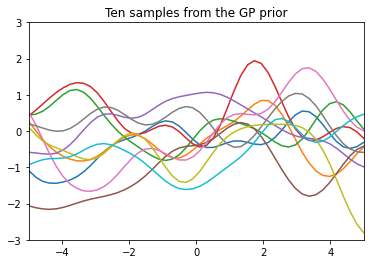

In [ ]:
# draw samples from the prior at our test points.
Lp = np.linalg.cholesky(K_ + 1e-6*np.eye(n))
f_prior = np.matmul(Lp, np.random.normal(size=(n,10)))

plt.figure(1)
plt.show()
plt.plot(Xtest, f_prior)
plt.title('Ten samples from the GP prior')
plt.axis([-5, 5, -3, 3])
plt.show()

### GP posterior

Remember from Bayes' rule:
for some measurements $D = \{(x_i,f_i), i = 1:N\}$, the probability that the underlying model is f is given by:

$p(f|D)=\frac{p(D|f)p(f)}{p(D)}$

i.e. $\text{posterior} = \frac{\text{evidence}\times\text{prior}}{\text{marginal likelihood}}$

<center><img src="https://raw.githubusercontent.com/VKapitany/Gaussian_Processes_Intro/master/mgt_2.png" width=600>

*(see https://www.cs.ubc.ca/~nando/540-2013/lectures/l6.pdf Eq. 4.12)*</center>

$p(f|D) = \mathcal{N}(f|\mu^{\prime}, \sigma^{\prime2})$




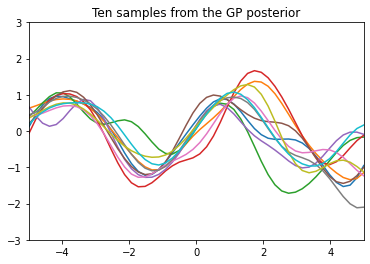

In [ ]:
# draw samples from the posterior at our test points.
Lp = np.linalg.cholesky(K_ + 1e-6*np.eye(n) - np.matmul(Lk.T, Lk)) #cholesky decomp of sigma'^2
f_post = mu.reshape(-1,1) + np.matmul(Lp, np.random.normal(size=(n,10))) #mean + sigma*N(0,1) at each point

plt.figure(3)
plt.clf()
plt.plot(Xtest, f_post)
plt.title('Ten samples from the GP posterior')
plt.axis([-5, 5, -3, 3])
plt.show()